In [1]:
import tensorflow as tf
import os
from utils import *
from tqdm import tqdm

In [2]:
attention_win_size = 3
max_N = 60
max_T = 120

def guided_attention(g=0.2):
    W = np.zeros((max_N, max_T), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(max_T) - n_pos / float(max_N)) ** 2 / (2 * g * g))
    return W

In [3]:
def Attention(Q, K, V, num_units, num_heads = 8, activation = None):
    T_k = tf.shape(K)[1]
    T_q = tf.shape(Q)[1]
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += Q
    x = layer_norm(x)
    return x, alignments

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def hc(inputs,
       filters=None,
       size=1,
       rate=1,
       padding="SAME",
       dropout_rate=0,
       use_bias=True,
       activation_fn=None,
       training=True,
       scope="hc",
       reuse=None):
    _inputs = inputs
    with tf.variable_scope(scope):
        if padding.lower() == "causal":
            pad_len = (size - 1) * rate
            inputs = tf.pad(inputs, [[0, 0], [pad_len, 0], [0, 0]])
            padding = "valid"

        if filters is None:
            filters = inputs.get_shape().as_list()[-1]


        params = {"inputs": inputs, "filters": 2*filters, "kernel_size": size,
                  "dilation_rate": rate, "padding": padding, "use_bias": use_bias,
                  "kernel_initializer": tf.contrib.layers.variance_scaling_initializer(), "reuse": reuse}

        tensor = tf.layers.conv1d(**params)
        H1, H2 = tf.split(tensor, 2, axis=-1)
        with tf.variable_scope('h1'):
            H1 = layer_norm(H1)
        with tf.variable_scope('h2'):
            H2 = layer_norm(H2)
        H1 = tf.nn.sigmoid(H1, "gate")
        H2 = activation_fn(H2, "info") if activation_fn is not None else H2
        tensor = H1*H2 + (1.-H1)*_inputs

    return tensor

def highwaynet(inputs, num_units=None, scope="highwaynet", reuse=None):
    if not num_units:
        num_units = inputs.get_shape()[-1]

    with tf.variable_scope(scope, reuse=reuse):
        H = tf.layers.dense(inputs, units=num_units, activation=tf.nn.relu, name="dense1")
        T = tf.layers.dense(inputs, units=num_units, activation=tf.nn.sigmoid,
                            bias_initializer=tf.constant_initializer(-1.0), name="dense2")
        outputs = H * T + inputs * (1. - T)
    return outputs

def conv1d_transpose(inputs,
                     filters=None,
                     size=3,
                     stride=2,
                     padding='same',
                     use_bias=True,
                     activation=None,
                     scope="conv1d_transpose",
                     reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        if filters is None:
            filters = inputs.get_shape().as_list()[-1]
        inputs = tf.expand_dims(inputs, 1)
        tensor = tf.layers.conv2d_transpose(inputs,
                                   filters=filters,
                                   kernel_size=(1, size),
                                   strides=(1, stride),
                                   padding=padding,
                                   activation=None,
                                   kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                                   use_bias=use_bias)
        tensor = tf.squeeze(tensor, 1)
        tensor = layer_norm(tensor)
        if activation is not None:
            tensor = activation(tensor)

    return tensor

def conv1d(inputs,
           filters=None,
           size=1,
           rate=1,
           padding="SAME",
           use_bias=True,
           activation_fn=None,
           scope="conv1d",
           reuse=None):
    with tf.variable_scope(scope):
        if padding.lower() == "causal":
            pad_len = (size - 1) * rate
            inputs = tf.pad(inputs, [[0, 0], [pad_len, 0], [0, 0]])
            padding = "valid"

        if filters is None:
            filters = inputs.get_shape().as_list()[-1]

        params = {"inputs": inputs, "filters": filters, "kernel_size": size,
                  "dilation_rate": rate, "padding": padding, "use_bias": use_bias,
                  "kernel_initializer": tf.contrib.layers.variance_scaling_initializer(), "reuse": reuse}

        tensor = tf.layers.conv1d(**params)
        tensor = layer_norm(tensor)
        if activation_fn is not None:
            tensor = activation_fn(tensor)

    return tensor

def text_encoder(tensor, d):
    i = 2
    tensor = conv1d(tensor,
                    filters=2*d,
                    size=1,
                    rate=1,
                    activation_fn=tf.nn.relu,
                    scope="C_{}".format(i)); i += 1
    tensor = conv1d(tensor,
                    size=1,
                    rate=1,
                    scope="C_{}".format(i)); i += 1

    for _ in range(2):
        for j in range(4):
            tensor = hc(tensor,
                            size=3,
                            rate=3**j,
                            activation_fn=None,
                            scope="HC_{}".format(i)); i += 1
    for _ in range(2):
        tensor = hc(tensor,
                        size=3,
                        rate=1,
                        activation_fn=None,
                        scope="HC_{}".format(i)); i += 1

    for _ in range(2):
        tensor = hc(tensor,
                        size=1,
                        rate=1,
                        activation_fn=None,
                        scope="HC_{}".format(i)); i += 1

    K, V = tf.split(tensor, 2, -1)
    return K, V

def audio_encoder(S, d):
    i = 1
    tensor = conv1d(S,
                    filters=d,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    activation_fn=tf.nn.relu,
                    scope="C_{}".format(i)); i += 1
    tensor = conv1d(tensor,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    activation_fn=tf.nn.relu,
                    scope="C_{}".format(i)); i += 1
    tensor = conv1d(tensor,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    scope="C_{}".format(i)); i += 1
    for _ in range(2):
        for j in range(4):
            tensor = hc(tensor,
                            size=3,
                            rate=3**j,
                            padding="CAUSAL",
                            scope="HC_{}".format(i)); i += 1
    for _ in range(2):
        tensor = hc(tensor,
                        size=3,
                        rate=3,
                        padding="CAUSAL",
                        scope="HC_{}".format(i)); i += 1

    return tensor

def audio_decoder(R, d):
    i = 1
    tensor = conv1d(R,
                    filters=d,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    scope="C_{}".format(i)); i += 1
    for j in range(4):
        tensor = hc(tensor,
                        size=3,
                        rate=3**j,
                        padding="CAUSAL",
                        scope="HC_{}".format(i)); i += 1

    for _ in range(2):
        tensor = hc(tensor,
                        size=3,
                        rate=1,
                        padding="CAUSAL",
                        scope="HC_{}".format(i)); i += 1
    for _ in range(3):
        tensor = conv1d(tensor,
                        size=1,
                        rate=1,
                        padding="CAUSAL",
                        activation_fn=tf.nn.relu,
                        scope="C_{}".format(i)); i += 1
    logits = conv1d(tensor,
                    filters=n_mels * resampled,
                    size=1,
                    rate=1,
                    padding="CAUSAL",
                    scope="C_{}".format(i)); i += 1
    Y = tf.nn.sigmoid(logits)

    return logits, Y

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        num_layers,
        size_layers,
        learning_rate = 1e-4,
        kernel_size = 5
    ):
        self.X = tf.placeholder(tf.int32, (None, None))
        lookup_table = tf.get_variable(
            'lookup_table',
            dtype = tf.float32,
            shape = [len(vocab), size_layers],
            initializer = tf.truncated_normal_initializer(
                mean = 0.0, stddev = 0.01
            ),
        )
        lookup_table = tf.concat(
            (tf.zeros(shape = [1, size_layers]), lookup_table[1:, :]), 0
        )
        self.gts = tf.convert_to_tensor(guided_attention())
        forward = tf.nn.embedding_lookup(lookup_table, self.X)
        self.Y = tf.placeholder(tf.float32, (None, None, n_mels * resampled))
        batch_size = tf.shape(self.Y)[0]
        self.decoder_inputs = tf.concat(
            (tf.ones_like(self.Y[:, :1, :]), self.Y[:, :-1, :]), 1
        )
        self.decoder_inputs = self.decoder_inputs[:, :, -n_mels:]
        
        self.Z = tf.placeholder(
            tf.float32, (None, None, fourier_window_size // 2 + 1)
        )
        
        with tf.variable_scope("text_encoder"):
            K, V = text_encoder(forward, size_layers)
        with tf.variable_scope("audio_encoder"):
            Q = audio_encoder(self.decoder_inputs, size_layers)
        
        train_R, self.alignments = Attention(Q, K, V, size_layers)
        
        with tf.variable_scope("audio_decoder"):
            self.Y_logits, self.Y_hat = audio_decoder(train_R, size_layers)
        
        out_decoder = tf.reshape(
                self.Y, [tf.shape(self.Y)[0], -1, n_mels]
        )
        out_decoder = tf.layers.dense(out_decoder, size_layers)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_vocoder_%d'%i):
                out_decoder += cnn_block(out_decoder, dilation_rate, pad_sz, size_layers, kernel_size)
        
        self.Z_logits = tf.layers.dense(out_decoder, 1 + fourier_window_size // 2)
        self.Z_hat = tf.sigmoid(self.Z_logits)
        
        self.loss1 = tf.reduce_mean(tf.abs(self.Y_hat - self.Y))
        self.loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Y_logits, 
                                                                               labels=self.Y))
        self.loss2 = tf.reduce_mean(tf.abs(self.Z_hat - self.Z))
        self.loss_bd2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Z_logits, 
                                                                          labels=self.Z))
        
        self.A = tf.pad(self.alignments, [(0, 0), (0, max_N), (0, max_T)], 
                        mode="CONSTANT", constant_values=-1.)[:, :max_N, :max_T]
        self.attention_masks = tf.to_float(tf.not_equal(self.A, -1))
        self.loss_att = tf.reduce_sum(tf.abs(self.A * self.gts) * self.attention_masks)
        self.mask_sum = tf.reduce_sum(self.attention_masks)
        self.loss_att /= self.mask_sum
        
        self.loss = self.loss1 + self.loss2 + self.loss_bd1 + self.loss_bd2 + self.loss_att
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.loss)

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

size_layers = 128
learning_rate = 1e-4
num_layers = 4

model = Model(num_layers, size_layers, learning_rate)
sess.run(tf.global_variables_initializer())

In [5]:
paths, lengths, texts, raw_texts = [], [], [], []
text_files = [f for f in os.listdir('mel') if f.endswith('.npy')]
for fpath in text_files:
    with open('%s/%s' % (path, fpath.replace('npy', 'txt'))) as fopen:
        text = fopen.read()
    paths.append(fpath.replace('.npy', ''))
    text = text_normalize(text)
    raw_texts.append(text)
    text = text + 'E'
    texts.append(np.array([char2idx[char] for char in text], np.int32))
    lengths.append(len(text))

In [6]:
def dynamic_batching(paths):
    files, max_y, max_z = [], 0, 0
    for n in range(len(paths)):
        files.append(get_cached(paths[n]))
        if files[-1][0].shape[0] > max_y:
            max_y = files[-1][0].shape[0]
        if files[-1][1].shape[0] > max_z:
            max_z = files[-1][1].shape[0]
    return files, max_y, max_z

In [7]:
batch_size = 8

minibatch loop: 100%|██████████| 350/350 [00:31<00:00, 11.17it/s, cost=1.64, loss1=0.274, loss2=0.0732, loss_att=0.00047, loss_bd1=0.728, loss_bd2=0.563] 


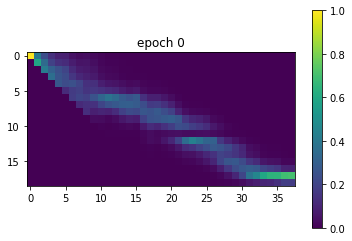

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.78it/s, cost=1.58, loss1=0.268, loss2=0.0634, loss_att=0.000353, loss_bd1=0.692, loss_bd2=0.558]


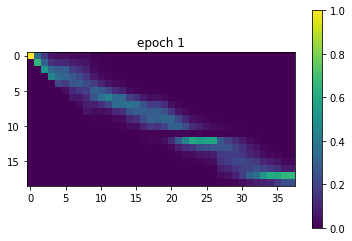

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.95it/s, cost=1.55, loss1=0.261, loss2=0.0594, loss_att=0.000273, loss_bd1=0.674, loss_bd2=0.556]


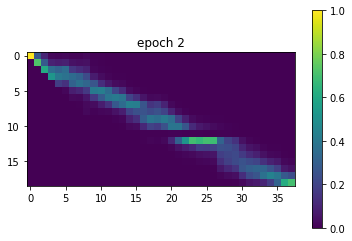

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.91it/s, cost=1.52, loss1=0.254, loss2=0.0567, loss_att=0.000242, loss_bd1=0.654, loss_bd2=0.555]


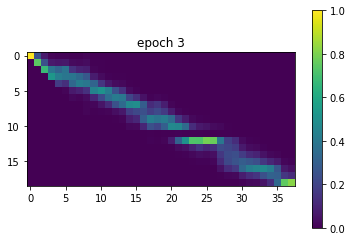

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.80it/s, cost=1.49, loss1=0.244, loss2=0.0549, loss_att=0.000223, loss_bd1=0.641, loss_bd2=0.554]


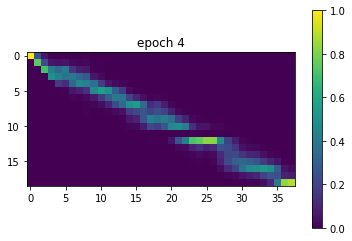

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.95it/s, cost=1.47, loss1=0.232, loss2=0.0537, loss_att=0.000214, loss_bd1=0.629, loss_bd2=0.553]


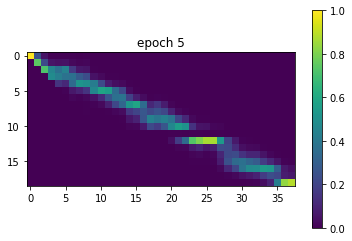

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.91it/s, cost=1.44, loss1=0.221, loss2=0.0526, loss_att=0.000211, loss_bd1=0.616, loss_bd2=0.553]


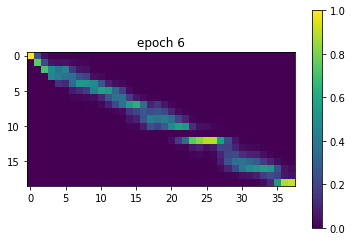

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.01it/s, cost=1.42, loss1=0.209, loss2=0.0516, loss_att=0.000212, loss_bd1=0.603, loss_bd2=0.552]


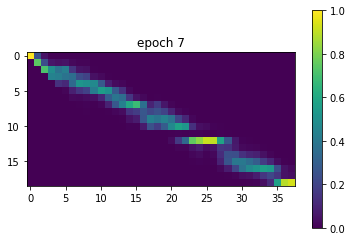

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.95it/s, cost=1.39, loss1=0.198, loss2=0.0507, loss_att=0.000214, loss_bd1=0.59, loss_bd2=0.552] 


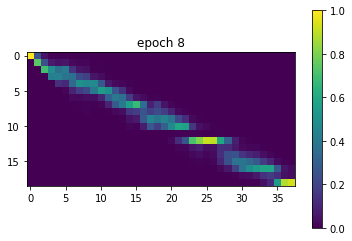

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.93it/s, cost=1.37, loss1=0.188, loss2=0.0498, loss_att=0.000216, loss_bd1=0.576, loss_bd2=0.551]


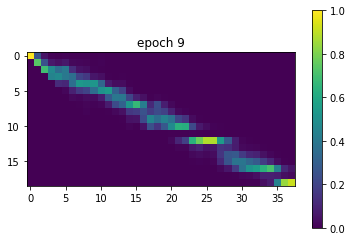

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.88it/s, cost=1.34, loss1=0.179, loss2=0.049, loss_att=0.000217, loss_bd1=0.564, loss_bd2=0.551] 


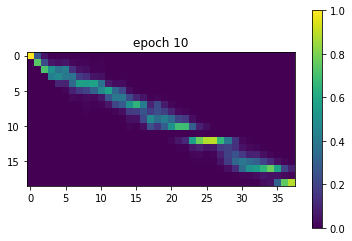

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.86it/s, cost=1.32, loss1=0.17, loss2=0.0482, loss_att=0.000219, loss_bd1=0.553, loss_bd2=0.551] 


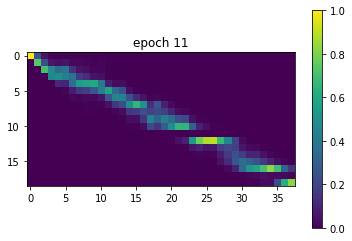

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.99it/s, cost=1.3, loss1=0.162, loss2=0.0475, loss_att=0.000217, loss_bd1=0.543, loss_bd2=0.55]  


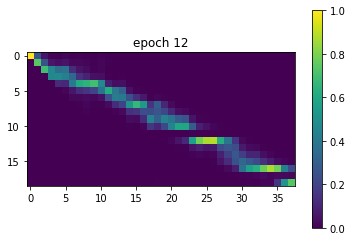

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.97it/s, cost=1.29, loss1=0.155, loss2=0.0469, loss_att=0.000211, loss_bd1=0.533, loss_bd2=0.55] 


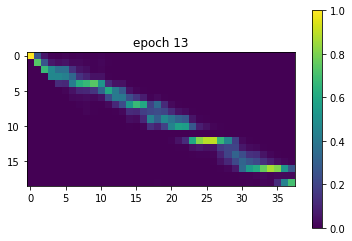

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.97it/s, cost=1.27, loss1=0.148, loss2=0.0463, loss_att=0.000209, loss_bd1=0.525, loss_bd2=0.55] 


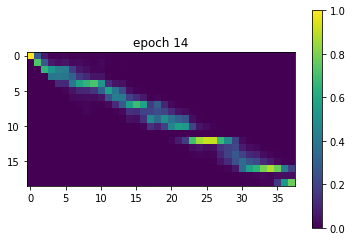

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.88it/s, cost=1.25, loss1=0.141, loss2=0.0458, loss_att=0.000209, loss_bd1=0.516, loss_bd2=0.55] 


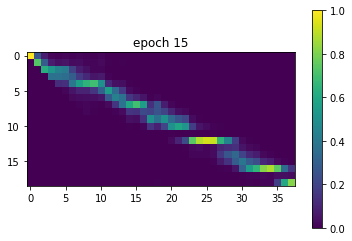

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.87it/s, cost=1.24, loss1=0.135, loss2=0.0453, loss_att=0.000206, loss_bd1=0.509, loss_bd2=0.55] 


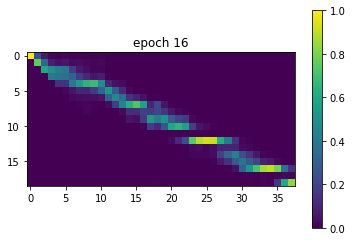

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.93it/s, cost=1.22, loss1=0.129, loss2=0.0449, loss_att=0.000207, loss_bd1=0.501, loss_bd2=0.549]


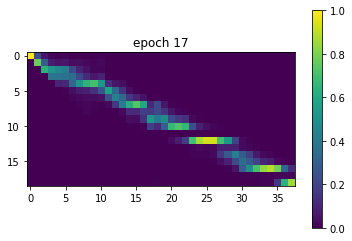

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.05it/s, cost=1.21, loss1=0.123, loss2=0.0445, loss_att=0.000206, loss_bd1=0.495, loss_bd2=0.549]


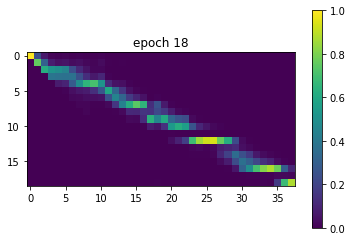

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.90it/s, cost=1.2, loss1=0.117, loss2=0.0441, loss_att=0.000206, loss_bd1=0.489, loss_bd2=0.549]  


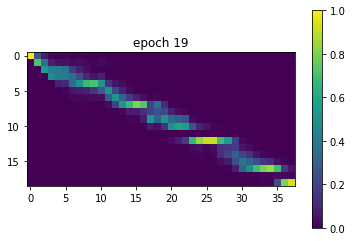

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.93it/s, cost=1.19, loss1=0.113, loss2=0.0438, loss_att=0.000207, loss_bd1=0.485, loss_bd2=0.549] 


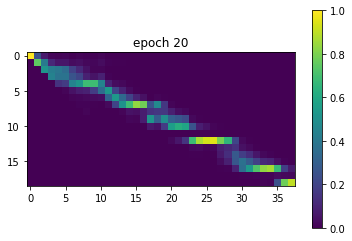

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.90it/s, cost=1.18, loss1=0.109, loss2=0.0435, loss_att=0.000211, loss_bd1=0.481, loss_bd2=0.549]


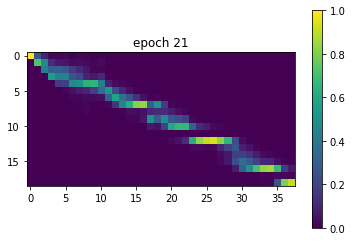

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.75it/s, cost=1.17, loss1=0.106, loss2=0.0432, loss_att=0.000216, loss_bd1=0.477, loss_bd2=0.549] 


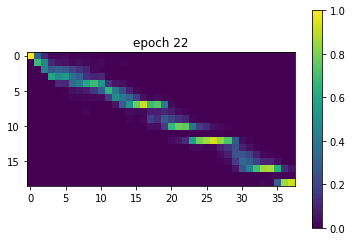

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.90it/s, cost=1.17, loss1=0.102, loss2=0.0429, loss_att=0.000219, loss_bd1=0.473, loss_bd2=0.549] 


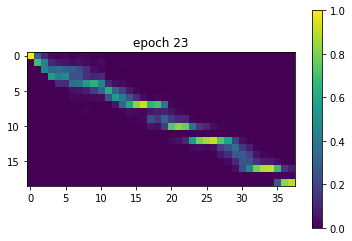

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.88it/s, cost=1.16, loss1=0.0997, loss2=0.0427, loss_att=0.000217, loss_bd1=0.47, loss_bd2=0.549] 


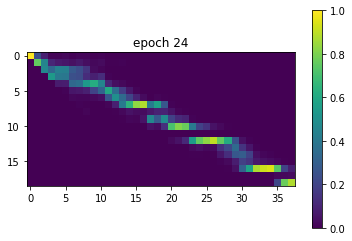

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.00it/s, cost=1.16, loss1=0.0973, loss2=0.0424, loss_att=0.00022, loss_bd1=0.468, loss_bd2=0.548] 


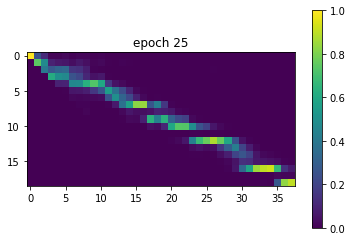

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.91it/s, cost=1.15, loss1=0.0953, loss2=0.0422, loss_att=0.00022, loss_bd1=0.465, loss_bd2=0.548] 


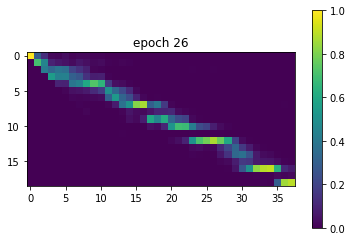

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.01it/s, cost=1.15, loss1=0.093, loss2=0.042, loss_att=0.000219, loss_bd1=0.463, loss_bd2=0.548]  


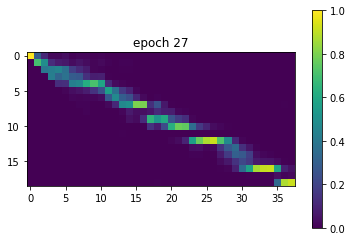

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.96it/s, cost=1.14, loss1=0.091, loss2=0.0418, loss_att=0.000209, loss_bd1=0.461, loss_bd2=0.548] 


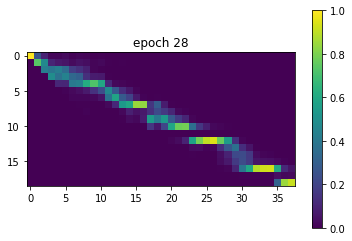

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.94it/s, cost=1.14, loss1=0.0894, loss2=0.0416, loss_att=0.000206, loss_bd1=0.459, loss_bd2=0.548]


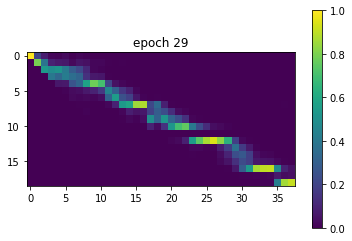

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.91it/s, cost=1.13, loss1=0.0875, loss2=0.0414, loss_att=0.000203, loss_bd1=0.457, loss_bd2=0.548] 


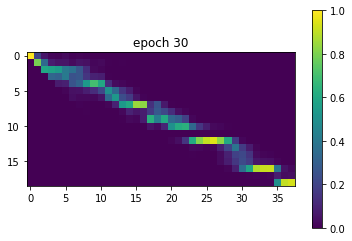

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.10it/s, cost=1.13, loss1=0.0855, loss2=0.0413, loss_att=0.000203, loss_bd1=0.455, loss_bd2=0.548] 


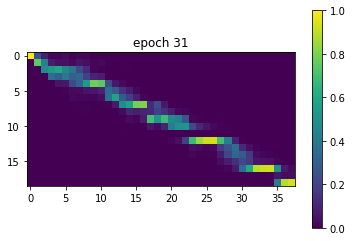

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.98it/s, cost=1.13, loss1=0.0832, loss2=0.0411, loss_att=0.000209, loss_bd1=0.453, loss_bd2=0.548] 


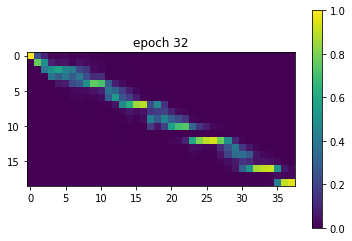

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.94it/s, cost=1.12, loss1=0.0815, loss2=0.041, loss_att=0.000209, loss_bd1=0.452, loss_bd2=0.548]  


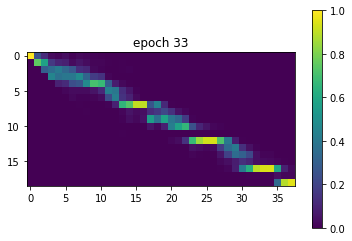

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.04it/s, cost=1.12, loss1=0.0796, loss2=0.0408, loss_att=0.000207, loss_bd1=0.45, loss_bd2=0.548]  


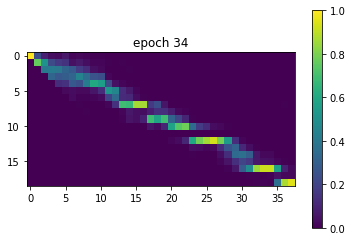

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.94it/s, cost=1.11, loss1=0.0773, loss2=0.0407, loss_att=0.000215, loss_bd1=0.448, loss_bd2=0.548] 


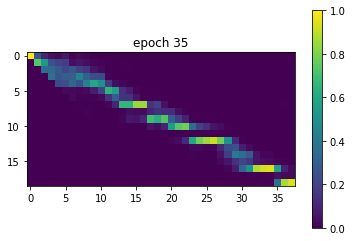

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.97it/s, cost=1.11, loss1=0.0756, loss2=0.0406, loss_att=0.000223, loss_bd1=0.446, loss_bd2=0.548] 


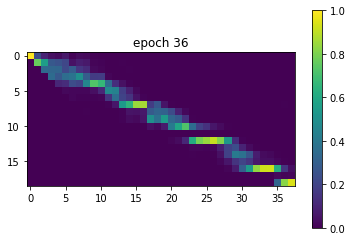

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.07it/s, cost=1.11, loss1=0.074, loss2=0.0405, loss_att=0.00022, loss_bd1=0.444, loss_bd2=0.548]   


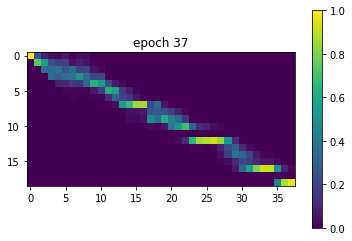

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.01it/s, cost=1.1, loss1=0.0725, loss2=0.0404, loss_att=0.000219, loss_bd1=0.443, loss_bd2=0.548]  


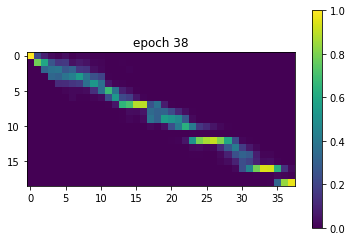

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.11it/s, cost=1.1, loss1=0.0714, loss2=0.0403, loss_att=0.000215, loss_bd1=0.442, loss_bd2=0.548]  


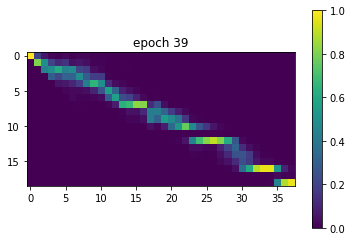

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.15it/s, cost=1.1, loss1=0.0698, loss2=0.0401, loss_att=0.000215, loss_bd1=0.44, loss_bd2=0.548]   


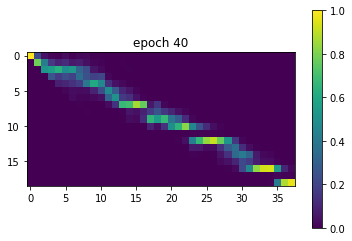

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.80it/s, cost=1.1, loss1=0.0687, loss2=0.0401, loss_att=0.00022, loss_bd1=0.439, loss_bd2=0.548]   


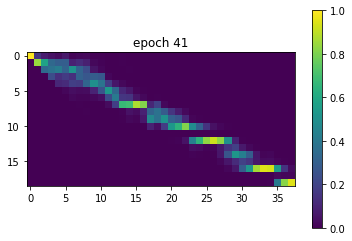

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 12.99it/s, cost=1.09, loss1=0.0671, loss2=0.04, loss_att=0.000217, loss_bd1=0.438, loss_bd2=0.548]   


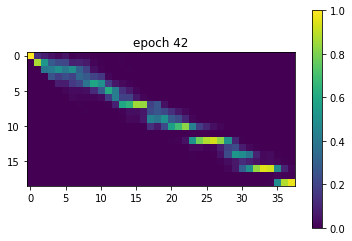

minibatch loop: 100%|██████████| 350/350 [00:27<00:00, 13.11it/s, cost=1.09, loss1=0.0655, loss2=0.0399, loss_att=0.000229, loss_bd1=0.437, loss_bd2=0.548] 


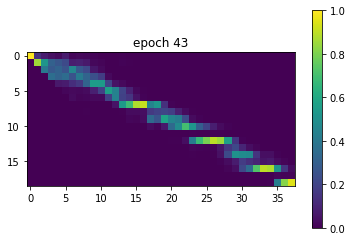

minibatch loop: 100%|██████████| 350/350 [00:26<00:00, 13.19it/s, cost=1.09, loss1=0.0644, loss2=0.0398, loss_att=0.00023, loss_bd1=0.436, loss_bd2=0.548]  


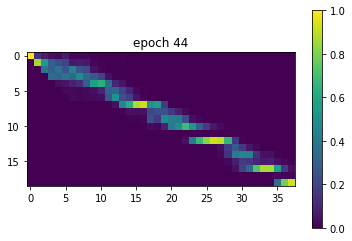

minibatch loop: 100%|██████████| 350/350 [00:26<00:00, 13.25it/s, cost=1.09, loss1=0.0633, loss2=0.0397, loss_att=0.000214, loss_bd1=0.435, loss_bd2=0.548] 


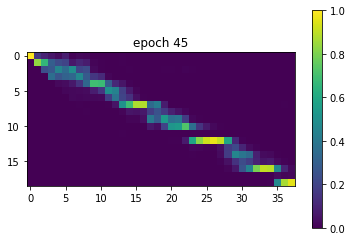

minibatch loop: 100%|██████████| 350/350 [00:26<00:00, 13.04it/s, cost=1.08, loss1=0.0625, loss2=0.0396, loss_att=0.000209, loss_bd1=0.434, loss_bd2=0.548] 


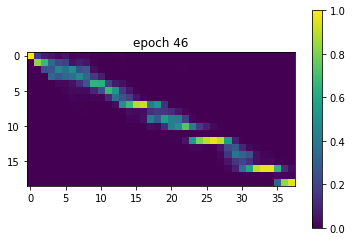

minibatch loop: 100%|██████████| 350/350 [00:26<00:00, 13.13it/s, cost=1.08, loss1=0.0616, loss2=0.0396, loss_att=0.000202, loss_bd1=0.433, loss_bd2=0.548] 


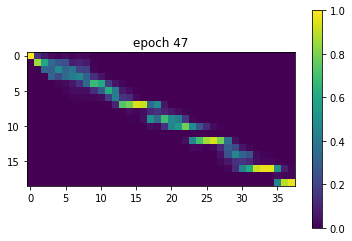

minibatch loop: 100%|██████████| 350/350 [00:26<00:00, 12.94it/s, cost=1.08, loss1=0.0605, loss2=0.0395, loss_att=0.000207, loss_bd1=0.432, loss_bd2=0.548] 


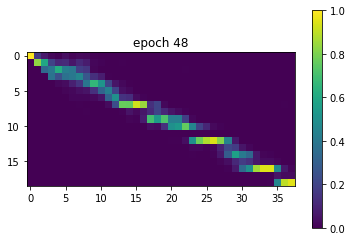

minibatch loop: 100%|██████████| 350/350 [00:26<00:00, 13.22it/s, cost=1.08, loss1=0.059, loss2=0.0394, loss_att=0.000215, loss_bd1=0.431, loss_bd2=0.547]  


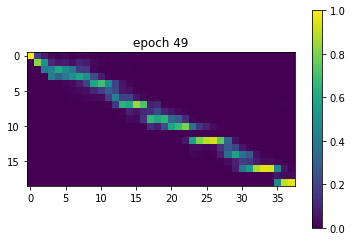

In [8]:
EPOCH = 50
for i in range(EPOCH):
    pbar = tqdm(range(0, len(paths), batch_size), desc = 'minibatch loop')
    for k in pbar:
        index = min(k + batch_size, len(paths))
        files, max_y, max_z = dynamic_batching(paths[k:index])
        max_x = max(lengths[k:index])
        batch_x = np.zeros((batch_size, max_x))
        batch_y = np.zeros((batch_size, max_y, n_mels * resampled))
        batch_z = np.zeros((batch_size, max_z, fourier_window_size // 2 + 1))
        for n in range(len(files)):
            batch_x[n, :] = np.pad(
                texts[k + n],
                ((0, max_x - texts[k + n].shape[0])),
                mode = 'constant',
            )
            batch_y[n, :, :] = np.pad(
                files[n][0],
                ((0, max_y - files[n][0].shape[0]), (0, 0)),
                mode = 'constant',
            )
            batch_z[n, :, :] = np.pad(
                files[n][1],
                ((0, max_z - files[n][1].shape[0]), (0, 0)),
                mode = 'constant',
            )
        _, cost, loss1, loss2, loss_bd1, loss_att, loss_bd2 = sess.run(
            [model.optimizer, model.loss, 
            model.loss1, model.loss2, model.loss_bd1,
            model.loss_att, model.loss_bd2],
            feed_dict = {model.X: batch_x, model.Y: batch_y, model.Z: batch_z},
        )
        pbar.set_postfix(cost = cost, loss1 = loss1, loss2 = loss2, loss_bd1 = loss_bd1,
                        loss_att = loss_att, loss_bd2 = loss_bd2)
        
    align = sess.run(
        model.alignments, feed_dict = {model.X: batch_x, model.Y: batch_y}
    )
    plot_alignment(align[0, :, :], i)

In [9]:
y_hat = np.ones((1, batch_y.shape[1], n_mels * resampled), np.float32)
for j in tqdm(range(batch_y.shape[1])):
    _y_hat = sess.run(model.Y_hat, {model.X: [texts[0]], model.Y: y_hat})
    y_hat[:, j, :] = _y_hat[:, j, :]

100%|██████████| 38/38 [00:00<00:00, 60.52it/s]


In [10]:
mags = sess.run(model.Z_hat, {model.Y: y_hat})
audio = spectrogram2wav(mags[0])

In [11]:
import IPython.display as ipd
ipd.Audio(audio, rate = sample_rate)

In [12]:
from scipy.io.wavfile import write
print('saving: %s'%(raw_texts[0]))
write(os.path.join('test-deep-cnn-self-attention.wav'), sample_rate, audio)

saving: say the word burn


In [13]:
mags = sess.run(model.Z_hat, {model.Y: [batch_y[0]]})
audio = spectrogram2wav(mags[0])
ipd.Audio(audio, rate = sample_rate)

In [14]:
real_audio = spectrogram2wav(batch_z[0])
ipd.Audio(real_audio, rate = sample_rate)